In [8]:
from transformers import AutoImageProcessor, ViTForImageClassification
from PIL import Image
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2
import random

In [9]:
model_name = "google/vit-base-patch16-224"

image_processor = AutoImageProcessor.from_pretrained(model_name, use_fast=True)
model = ViTForImageClassification.from_pretrained(model_name, output_attentions=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

cuda


In [10]:
def mask_center_patches(inputs, center_fraction=0.3):
    pixel_values = inputs["pixel_values"]
    B, C, H, W = pixel_values.shape
    patch_size = 16
    num_patches_side = H // patch_size

    patches = pixel_values.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
    patches = patches.contiguous().view(B, C, num_patches_side, num_patches_side, patch_size, patch_size)

    block_size = int(num_patches_side * center_fraction)
    start = (num_patches_side - block_size) // 2
    end = start + block_size

    patches[:, :, start:end, start:end, :, :] = 0.0

    patches = patches.view(B, C, num_patches_side, num_patches_side, patch_size, patch_size)
    patches = patches.permute(0, 1, 2, 4, 3, 5).contiguous()
    masked_pixel_values = patches.view(B, C, H, W)

    return {"pixel_values": masked_pixel_values}


In [11]:
img_paths = [
    "img/bicycle-built-for-two.jpg",
    "img/rubber_eraser.jpg",
    "img/seat_belt.jpg",
    "img/space_shuttle.jpg",
    "img/vacuum.jpg"
]

images = [Image.open(path).convert("RGB") for path in img_paths]
inputs = image_processor(images=images, return_tensors="pt")
masked_inputs = mask_center_patches(inputs, center_fraction=0.5)

In [12]:
model.eval()
with torch.no_grad():
    outputs = model(**masked_inputs)
    attentions = outputs.attentions
    logits = outputs.logits

predicted_ids = logits.argmax(dim=1).tolist()
labels = model.config.id2label
for i, pred in enumerate(predicted_ids):
    print(f"Image {i+1}: {labels[pred]}")

Image 1: bicycle-built-for-two, tandem bicycle, tandem
Image 2: menu
Image 3: car mirror
Image 4: bell cote, bell cot
Image 5: vacuum, vacuum cleaner


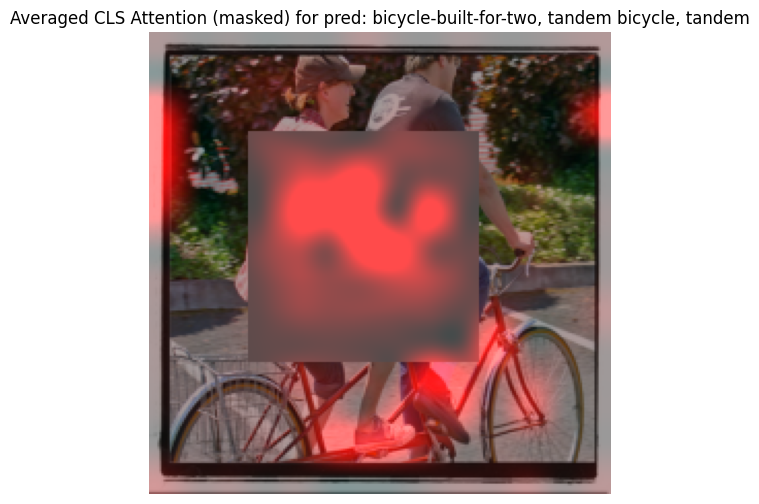

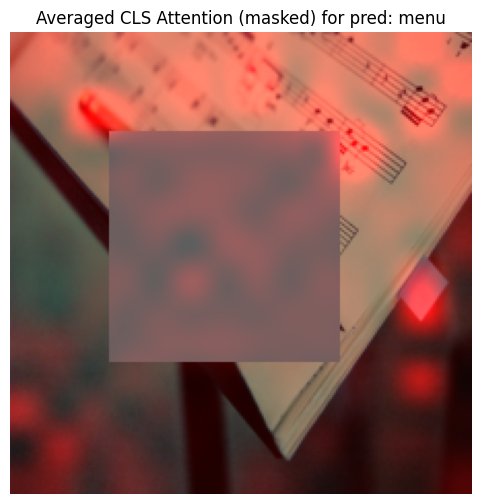

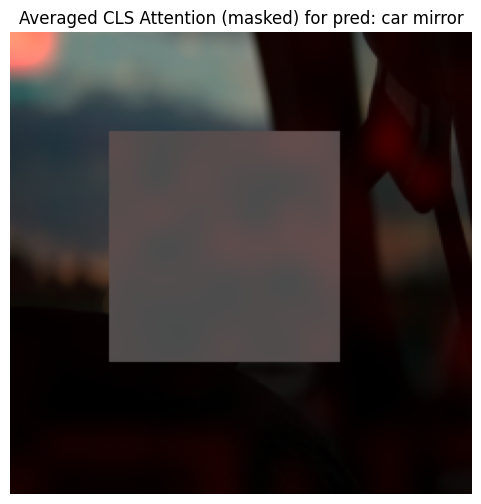

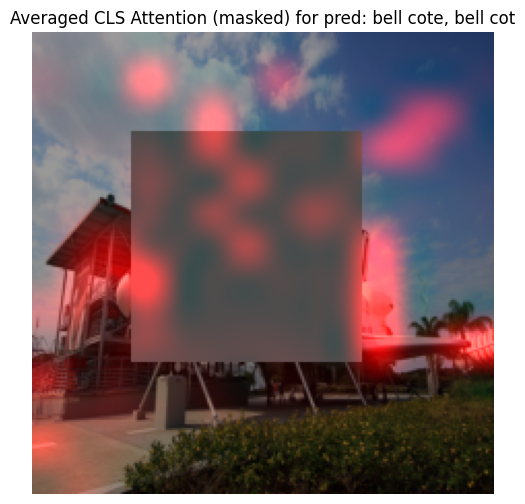

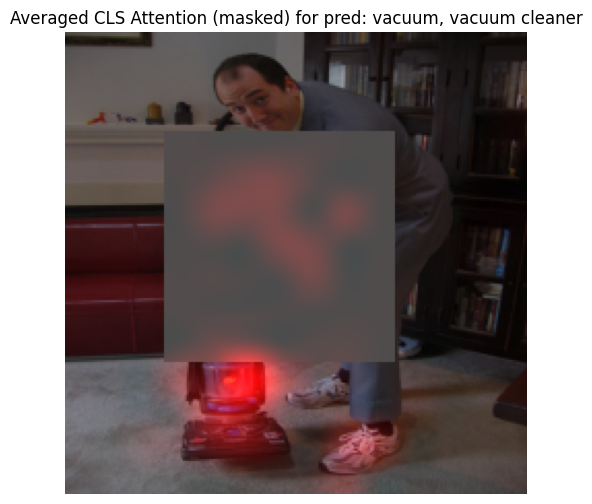

In [13]:
for idx, img in enumerate(images):
    cls_attn = attentions[-1][idx]
    cls_attn = cls_attn.mean(dim=0)
    cls_attn_vector = cls_attn[0, 1:]
    attn_map = cls_attn_vector.reshape(14, 14).cpu().numpy()
    attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min())

    attn_map_resized = cv2.resize(attn_map, (224, 224), interpolation=cv2.INTER_CUBIC)

    masked_img_tensor = masked_inputs["pixel_values"][idx].cpu()
    masked_img_np = masked_img_tensor.permute(1, 2, 0).numpy()
    masked_img_np = (masked_img_np - masked_img_np.min()) / (masked_img_np.max() - masked_img_np.min())

    heatmap = np.zeros_like(masked_img_np)
    heatmap[:, :, 0] = attn_map_resized
    
    overlay = 0.6 * masked_img_np + heatmap
    overlay = np.clip(overlay, 0, 1)

    plt.figure(figsize=(6, 6))
    plt.imshow(overlay)
    plt.axis("off")
    plt.title(f"Averaged CLS Attention (masked) for pred: {labels[predicted_ids[idx]]}")
    plt.show()
